This script creates a csv which holds the corresponding validation data points from both Chesapeake Bay Program's (CBP) Water Quality dataset and the two satellite datasets. The csv contains one row for each day and pixel in which there was a CBP validation point, and either a MUR or a Geopolar satellite pixel.

Before running this script, be sure to run:
1. (`01_download_CPBWaterQuality_data.py`) download CBP Water Quality dataset
2. (`.py`) download/access Geopolar
3. (`.py`) download/access MUR

In [12]:
import xarray as xr
import pandas as pd
import numpy as np

In [13]:
pd.set_option('display.max_rows', 200)

In [14]:
# cols = ['EventId', 'SampleDate', 'SampleTime', 
#         'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
# wq2 = pd.read_csv('./data/WaterQualityWaterQualityStation.csv', usecols=cols)  # , skipfooter=1)
# # wq = wq.drop([521779])  # Remove the empty bottom row
# wq2['SampleDate'] = pd.to_datetime(wq2['SampleDate'], format='%m/%d/%Y')

In [15]:
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
wq = pd.read_csv('./data/raw/WaterQuality_ChesapeakeBayProgram.csv', usecols=cols)  # , skipfooter=1)
# wq = wq.drop([521779])  # Remove the empty bottom row
wq['SampleDate'] = pd.to_datetime(wq['SampleDate'], format='%m/%d/%Y')
# # Remove rows before the beginning of the geopolar collection period
# wq = wq[wq['SampleDate'] >= '2002-09-01']
# wq = wq[wq['SampleDate'] <= '2022-03-20']
# # Remove rows that have a null SST value
wq = wq[~wq['MeasureValue'].isnull()]
wq = wq.sort_values('SampleDate').reset_index(drop=True)

In [16]:
wq

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
0,67626.0,WQN0273,2003-01-02,15:00:00,0.0,I,6.500,DEG C,39.94649,-76.36774
1,67628.0,WQN0201,2003-01-02,16:00:00,0.0,I,6.000,DEG C,40.05454,-76.53080
2,67625.0,WQN0301,2003-01-02,12:55:00,0.0,I,3.000,DEG C,40.95814,-76.61912
3,67629.0,WQN0401,2003-01-02,17:20:00,0.0,I,3.100,DEG C,40.96814,-76.87330
4,67627.0,WQN0305,2003-01-02,15:10:00,0.0,I,1.700,DEG C,41.76535,-76.44050
...,...,...,...,...,...,...,...,...,...,...
565719,608299.0,CB6.3,2022-06-30,14:43:00,9.0,M,23.382,DEG C,37.41153,-76.15966
565720,608296.0,CB6.2,2022-06-30,09:17:00,2.0,M,24.571,DEG C,37.48680,-76.15633
565721,608296.0,CB6.2,2022-06-30,09:17:00,7.0,BP,23.095,DEG C,37.48680,-76.15633
565722,608284.0,CB5.4,2022-06-30,11:59:00,18.0,M,23.548,DEG C,37.80013,-76.17466


### Quality Checks

In [4]:
# Make sure all values have unit of Celcius
assert len(np.unique(wq.Unit)) == 1
assert np.unique(wq.Unit) == ['DEG C']

In [5]:
assert len(wq[wq.MeasureValue > 100]) == 0

AssertionError: 

In [11]:
wq = wq[wq.MeasureValue < 100]

### Filtering: Points below a certain depth

Double check units. Pick bulk temperature. Don't count the same place more than once.

Check that moorings also measure at night. I could take the nighttime ones outspecifically. Could also look at curve to see.

Could look at the docs for L3S ACSPO data has a curve for the two daytime and nighttime overpasses and the diurnal warming pattern.

Read on "Layer" metadata column?

In [18]:
wq[wq.Station == 'LE1.4'].sort_values(['SampleDate', 'SampleTime', 'Depth']).head(50)

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
64,67653.0,LE1.4,2003-01-06,09:03:00,0.5,S,4.1,DEG C,38.312,-76.42151
38,67653.0,LE1.4,2003-01-06,09:03:00,3.0,AP,4.4,DEG C,38.312,-76.42151
28,67653.0,LE1.4,2003-01-06,09:03:00,6.0,M,4.5,DEG C,38.312,-76.42151
65,67653.0,LE1.4,2003-01-06,09:03:00,9.0,BP,4.6,DEG C,38.312,-76.42151
52,67653.0,LE1.4,2003-01-06,09:03:00,12.0,B,4.7,DEG C,38.312,-76.42151
35,67653.0,LE1.4,2003-01-06,09:03:00,15.0,M,4.7,DEG C,38.312,-76.42151
1146,72092.0,LE1.4,2003-02-06,08:58:00,0.5,S,0.7,DEG C,38.312,-76.42151
1107,72092.0,LE1.4,2003-02-06,08:58:00,3.0,AP,0.8,DEG C,38.312,-76.42151
1106,72092.0,LE1.4,2003-02-06,08:58:00,6.0,M,1.0,DEG C,38.312,-76.42151
1125,72092.0,LE1.4,2003-02-06,08:58:00,9.0,BP,1.0,DEG C,38.312,-76.42151


In [25]:
wq_bydate = wq.groupby(['Station', 'SampleDate']).count()['EventId']

In [29]:
moorings_maybe = wq_bydate[wq_bydate > 23]

In [36]:
moorings_maybe.index.unique(level='Station')

Index(['ARF.MS1B', 'ARF.MS2', 'CB3.3C', 'CB4.1C', 'CB4.1E', 'CB4.2C', 'CB4.3C',
       'CB4.3E', 'CB4.4', 'CB5.1', 'CB5.2', 'CB5.3', 'CB5.4', 'CB7.1N',
       'CB7.3E', 'CHK015.12', 'EE3.2', 'EE3.5', 'LE2.2'],
      dtype='object', name='Station')

In [40]:
wq[wq.Station == 'ARF.MS2'].sort_values(['SampleDate', 'SampleTime', 'Depth']).head(50)

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
449681,572063.0,ARF.MS2,2019-04-23,13:26:00,0.50,VP,18.83,DEG C,38.94921,-76.54695
449571,572063.0,ARF.MS2,2019-04-23,13:26:00,1.00,VP,18.81,DEG C,38.94921,-76.54695
449627,572063.0,ARF.MS2,2019-04-23,13:26:00,1.50,VP,18.59,DEG C,38.94921,-76.54695
449731,572063.0,ARF.MS2,2019-04-23,13:26:00,2.00,VP,18.16,DEG C,38.94921,-76.54695
449733,572063.0,ARF.MS2,2019-04-23,13:26:00,2.50,VP,18.02,DEG C,38.94921,-76.54695
449420,572063.0,ARF.MS2,2019-04-23,13:26:00,3.00,VP,18.00,DEG C,38.94921,-76.54695
449672,572063.0,ARF.MS2,2019-04-23,13:26:00,3.50,VP,17.96,DEG C,38.94921,-76.54695
449683,572063.0,ARF.MS2,2019-04-23,13:26:00,4.00,VP,17.88,DEG C,38.94921,-76.54695
449607,572063.0,ARF.MS2,2019-04-23,13:26:00,4.50,VP,17.83,DEG C,38.94921,-76.54695
449632,572063.0,ARF.MS2,2019-04-23,13:26:00,5.00,VP,17.77,DEG C,38.94921,-76.54695


### Searching for stations with obs on consecutive days

In [47]:
wq = wq[(wq.Depth > 0.1) & (wq.Depth < 4)]

## Creating a single value for each date & location

In [48]:
wq['Datetime'] = pd.to_datetime(wq['SampleDate'].dt.strftime('%Y-%m-%d') + ' ' + wq['SampleTime'])

# wq = wq.groupby([(wq['Datetime'].dt.date), 'Latitude', 'Longitude']).mean()

In [51]:
wq = wq.reset_index()
wq = wq.rename(columns={'Datetime': 'SampleDate'})

In [57]:
wq[wq.SampleTime == '02:00:00']

,index,EventId,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude,SampleDate
252660,516324,612203.0,2021-03-03,02:00:00,0.3,S,10.1,DEG C,37.07523,-76.329,2021-03-03 02:00:00


In [76]:
wq_daily = wq.groupby(['Station', 'SampleDate']).mean()
wq_daily = wq_daily.sort_index()

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_70143/3948030051.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wq_daily = wq.groupby(['Station', 'SampleDate']).mean()


In [74]:
wq_daily

EventId  Depth  MeasureValue  Latitude  Longitude  \
Station  SampleDate                                                       
01491000 2011-10-12  409036.0   0.00     17.400000  38.99722  -75.78611   
         2011-11-07  409037.0   0.00      9.000000  38.99722  -75.78611   
         2011-12-01  409038.0   0.00      9.000000  38.99722  -75.78611   
         2011-12-08  409039.0   0.00     10.800000  38.99722  -75.78611   
         2012-01-09  409040.0   0.00      5.100000  38.99722  -75.78611   
...                       ...    ...           ...       ...        ...   
ZDM0003  2004-08-31   37977.0   0.75     27.350000  38.93620  -76.50670   
         2004-09-15   38264.0   1.00     24.366667  38.93620  -76.50670   
         2004-09-29   38552.0   0.75     22.250000  38.93620  -76.50670   
         2004-10-13   38803.0   1.00     17.266667  38.93620  -76.50670   
         2004-10-27   39089.0   0.75     14.900000  38.93620  -76.50670   

                          Date  
Station  SampleDate             
01491000 2011-10-12 2011-10-12  
         2011-11-07 2011-11-07  
         2011-12-01 2011-12-01  
         2011-12-08 2011-12-08  
         2012-01-09 2012-01-09  
...                        ...  
ZDM0003  2004-08-31 2004-08-31  
         2004-09-15 2004-09-15  
         2004-09-29 2004-09-29  
         2004-10-13 2004-10-13  
         2004-10-27 2004-10-27  

[139062 rows x 6 columns]

In [77]:
wq_daily['Date'] = wq_daily.index.get_level_values(1)

In [78]:
wq_daily_diff = wq_daily.diff()

In [79]:
wq_daily_diff

EventId  Depth  MeasureValue  Latitude  Longitude    Date
Station  SampleDate                                                           
01491000 2011-10-12      NaN    NaN           NaN       NaN        NaN     NaT
         2011-11-07      1.0   0.00     -8.400000       0.0        0.0 26 days
         2011-12-01      1.0   0.00      0.000000       0.0        0.0 24 days
         2011-12-08      1.0   0.00      1.800000       0.0        0.0  7 days
         2012-01-09      1.0   0.00     -5.700000       0.0        0.0 32 days
...                      ...    ...           ...       ...        ...     ...
ZDM0003  2004-08-31    191.0  -0.25      0.816667       0.0        0.0 12 days
         2004-09-15    287.0   0.25     -2.983333       0.0        0.0 15 days
         2004-09-29    288.0  -0.25     -2.116667       0.0        0.0 14 days
         2004-10-13    251.0   0.25     -4.983333       0.0        0.0 14 days
         2004-10-27    286.0  -0.25     -2.366667       0.0        0.0 14 days

[139062 rows x 6 columns]

In [61]:
from datetime import timedelta

In [85]:
wq_daily_diff[wq_daily_diff.Date == timedelta(days=1)]

EventId     Depth  MeasureValue  Latitude     Longitude  \
Station   SampleDate                                                            
01491000  2012-11-01      1.0  0.000000      0.400000       0.0  0.000000e+00   
          2015-06-02      1.0  0.000000     -3.300000       0.0  0.000000e+00   
          2016-07-06      1.0  0.000000      2.100000       0.0  0.000000e+00   
          2017-03-16      1.0  0.000000     -1.000000       0.0  0.000000e+00   
01493112  2012-10-31      1.0  0.000000      0.900000       0.0  0.000000e+00   
...                       ...       ...           ...       ...           ...   
YRK015.09 2007-03-14     42.0 -0.116667      0.433333       0.0  0.000000e+00   
          2007-08-29     10.0 -0.123611     -0.220139       0.0  0.000000e+00   
          2008-07-23     32.0  0.000000     -0.688000       0.0  0.000000e+00   
          2008-08-22     32.0 -0.122619     -0.173810       0.0 -1.421085e-14   
ZDM0001   2004-10-27     27.0  0.100000      0.075000       0.0  0.000000e+00   

                       Date  
Station   SampleDate         
01491000  2012-11-01 1 days  
          2015-06-02 1 days  
          2016-07-06 1 days  
          2017-03-16 1 days  
01493112  2012-10-31 1 days  
...                     ...  
YRK015.09 2007-03-14 1 days  
          2007-08-29 1 days  
          2008-07-23 1 days  
          2008-08-22 1 days  
ZDM0001   2004-10-27 1 days  

[2734 rows x 6 columns]

In [94]:
wq[(wq.SampleTime < '06:00')]

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
13363,54711.0,SEV0116,2003-08-11,05:44:00,1.7,M,27.0,DEG C,39.08180,-76.61120
13367,54711.0,SEV0116,2003-08-11,05:44:00,1.5,M,27.1,DEG C,39.08180,-76.61120
13439,54711.0,SEV0116,2003-08-11,05:44:00,1.0,M,27.4,DEG C,39.08180,-76.61120
13440,54711.0,SEV0116,2003-08-11,05:44:00,0.5,BS,27.1,DEG C,39.08180,-76.61120
13448,54749.0,CTT0001,2003-08-12,05:43:00,1.5,M,28.0,DEG C,39.08497,-76.52428
...,...,...,...,...,...,...,...,...,...,...
560440,616302.0,CS.SNR-018.82,2021-12-14,01:30:00,0.3,S,10.2,DEG C,36.74097,-76.57790
560442,616303.0,CS.SNR-019.27,2021-12-14,01:40:00,0.3,S,10.2,DEG C,36.74004,-76.58430
560444,616304.0,CS.SNR-019.46,2021-12-14,01:41:00,0.3,S,9.9,DEG C,36.74271,-76.58527
560459,616300.0,CS.SNR-018.24,2021-12-14,01:11:00,0.3,S,9.7,DEG C,36.74747,-76.57391


In [102]:
wq[(wq.SampleTime < '04:00') | (wq.SampleTime > '22:00')] \
    .sort_values(['Station', 'SampleDate', 'SampleTime', 'Depth']).head(200)

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
298292,408012.0,01529500,2013-09-11,22:00:00,0.00,S,22.89,DEG C,42.25250,-77.21694
406460,563593.0,ACB.53,2017-10-20,01:00:00,0.30,S,17.90,DEG C,37.56040,-77.54530
508471,578383.0,ACB.ARF,2020-10-17,01:38:00,0.30,S,15.00,DEG C,37.30734,-78.38926
508483,578383.0,ACB.ARF,2020-10-17,01:38:00,0.30,S,15.00,DEG C,37.30734,-78.38926
512739,611615.0,ACB.BLACRE0.6,2021-01-02,01:50:00,0.30,S,9.90,DEG C,37.40704,-76.64815
553181,614451.0,ACB.BLACRE0.6,2021-10-06,23:51:00,0.30,S,24.70,DEG C,37.40704,-76.64815
553297,614451.0,ACB.BLACRE0.6,2021-10-06,23:51:00,0.30,S,24.60,DEG C,37.40704,-76.64815
511136,578433.0,ACB.BUFCRE10,2020-11-19,22:42:00,0.30,S,8.20,DEG C,37.74250,-79.50660
487172,578447.0,ACB.BUSMILCRE,2020-02-19,01:30:00,0.30,S,11.00,DEG C,37.87506,-76.44137
511129,578505.0,ACB.COLCRE0.5,2020-11-19,23:20:00,0.30,S,8.30,DEG C,37.76260,-79.54902


**Conclusion: there aren't any buoys in this dataset 🫢** 

### What is the foundation depth?

In [105]:
wq[wq.Layer == 'VP']

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
6492,73198.0,YRK001.20,2003-05-12,09:11:00,0.5,VP,19.4,DEG C,37.22727,-76.42280
6493,73212.0,YRK005.40,2003-05-12,12:44:00,0.5,VP,18.8,DEG C,37.24828,-76.49651
6494,73213.0,MOB006.12,2003-05-12,13:12:00,0.5,VP,21.1,DEG C,37.25818,-76.38902
6496,73201.0,YRK006.77,2003-05-12,09:46:00,0.5,VP,19.1,DEG C,37.24432,-76.52430
6507,73209.0,YRK010.59,2003-05-12,12:10:00,0.5,VP,21.6,DEG C,37.29657,-76.56287
...,...,...,...,...,...,...,...,...,...,...
560423,618489.0,MDE.0804019,2021-12-13,10:02:00,1.0,VP,7.9,DEG C,38.89833,-76.31333
560425,618489.0,MDE.0804019,2021-12-13,10:02:00,0.5,VP,7.9,DEG C,38.89833,-76.31333
560629,618490.0,MDE.0808044,2021-12-15,09:51:00,1.0,VP,7.4,DEG C,38.75333,-76.30778
560631,618490.0,MDE.0808044,2021-12-15,09:51:00,1.7,VP,7.3,DEG C,38.75333,-76.30778


In [124]:
wq[wq.Station == 'MDE.0804019'].sort_values(['SampleDate', 'SampleTime', 'Depth'])

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
446390,575209.0,MDE.0804019,2019-03-18,10:00:00,0.5,VP,7.3,DEG C,38.89833,-76.31333
446370,575209.0,MDE.0804019,2019-03-18,10:00:00,1.0,VP,7.3,DEG C,38.89833,-76.31333
446364,575209.0,MDE.0804019,2019-03-18,10:00:00,2.0,VP,7.3,DEG C,38.89833,-76.31333
446907,575210.0,MDE.0804019,2019-04-02,10:07:00,0.5,VP,9.4,DEG C,38.89833,-76.31333
446910,575210.0,MDE.0804019,2019-04-02,10:07:00,1.0,VP,9.4,DEG C,38.89833,-76.31333
446903,575210.0,MDE.0804019,2019-04-02,10:07:00,2.0,VP,9.4,DEG C,38.89833,-76.31333
454629,575211.0,MDE.0804019,2019-06-04,10:04:00,0.5,VP,23.2,DEG C,38.89833,-76.31333
454623,575211.0,MDE.0804019,2019-06-04,10:04:00,1.0,VP,23.1,DEG C,38.89833,-76.31333
454622,575211.0,MDE.0804019,2019-06-04,10:04:00,2.0,VP,23.0,DEG C,38.89833,-76.31333
457449,575212.0,MDE.0804019,2019-06-19,10:04:00,0.5,VP,24.9,DEG C,38.89833,-76.31333


<AxesSubplot: xlabel='MeasureValue', ylabel='Depth'>

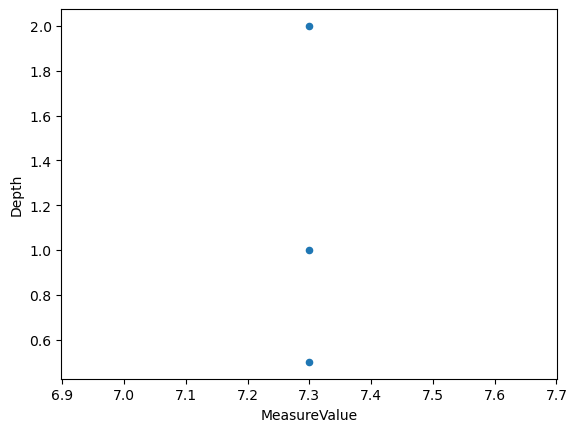

In [125]:
wq[(wq.Station == 'MDE.0804019') & (wq.SampleDate == '2019-03-18')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

In [126]:
np.unique(wq[wq.Station == 'CB4.1C'].sort_values(['SampleDate', 'SampleTime', 'Depth']).SampleDate)

array(['2003-01-14T00:00:00.000000000', '2003-02-14T00:00:00.000000000',
       '2003-03-11T00:00:00.000000000', '2003-04-08T00:00:00.000000000',
       '2003-04-22T00:00:00.000000000', '2003-05-06T00:00:00.000000000',
       '2003-05-20T00:00:00.000000000', '2003-06-17T00:00:00.000000000',
       '2003-07-08T00:00:00.000000000', '2003-07-22T00:00:00.000000000',
       '2003-08-05T00:00:00.000000000', '2003-08-19T00:00:00.000000000',
       '2003-09-16T00:00:00.000000000', '2003-09-23T00:00:00.000000000',
       '2003-10-07T00:00:00.000000000', '2003-11-18T00:00:00.000000000',
       '2003-12-17T00:00:00.000000000', '2004-01-13T00:00:00.000000000',
       '2004-02-18T00:00:00.000000000', '2004-03-16T00:00:00.000000000',
       '2004-04-13T00:00:00.000000000', '2004-04-27T00:00:00.000000000',
       '2004-05-11T00:00:00.000000000', '2004-05-25T00:00:00.000000000',
       '2004-06-08T00:00:00.000000000', '2004-06-23T00:00:00.000000000',
       '2004-07-07T00:00:00.000000000', '2004-07-20

A summer profile (warmer on top!)

<AxesSubplot: xlabel='MeasureValue', ylabel='Depth'>

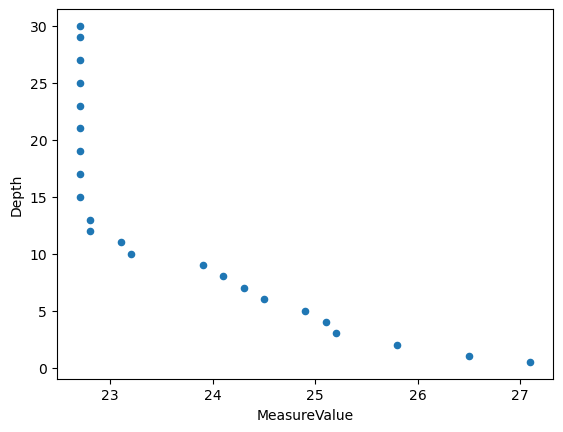

In [129]:
wq[(wq.Station == 'CB4.1C') & (wq.SampleDate == '2004-07-20')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

A winter profile (warmer underneath!)

<AxesSubplot: xlabel='MeasureValue', ylabel='Depth'>

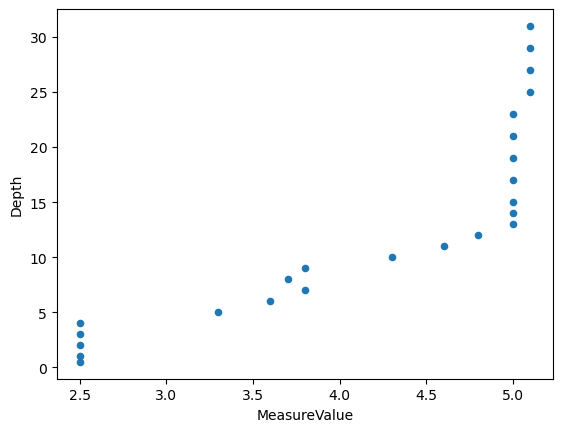

In [128]:
wq[(wq.Station == 'CB4.1C') & (wq.SampleDate == '2003-01-14')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

<AxesSubplot: xlabel='MeasureValue', ylabel='Depth'>

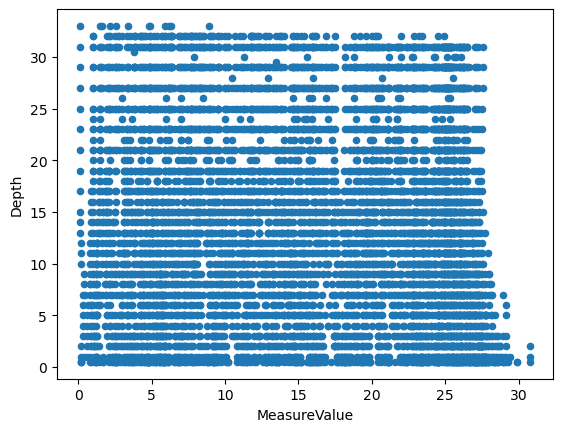

In [123]:
wq[(wq.Station == 'CB4.1C')].sort_values('Depth').plot \
.scatter(x='MeasureValue', y='Depth')

In [135]:
wq[wq.Depth > 7].groupby(['Station', 'SampleDate'])['MeasureValue'].mean()

Station    SampleDate
APP001.53  2006-04-27    20.933333
           2006-05-26    23.590000
           2006-06-23    29.246667
           2006-07-28    30.460000
           2006-08-25    29.283333
                           ...    
YRK000.79  2012-07-17    26.562000
           2012-08-21    26.364000
           2012-09-17    24.420000
           2012-10-15    17.958000
           2012-11-05    12.796000
Name: MeasureValue, Length: 21859, dtype: float64

In [17]:
wq = wq[wq.Depth >=2 ].groupby(['Station', 'SampleDate', 'Latitude', 'Longitude'])['MeasureValue'].mean()

In [18]:
wq = wq.reset_index()

In [19]:
wq

,Station,SampleDate,Latitude,Longitude,MeasureValue
0,1AAUA001.39,2008-05-19,38.40000,-77.32000,17.4
1,1AAUA001.39,2009-05-19,38.40000,-77.32000,18.4
2,1AAUA001.39,2009-07-27,38.40000,-77.32000,27.8
3,1AAUA003.71,2011-03-24,38.42305,-77.35528,13.2
4,1AAUA003.71,2011-08-24,38.42305,-77.35528,26.0
...,...,...,...,...,...
49018,ZDM0000,2004-10-27,38.93500,-76.50800,15.3
49019,ZDM0001,2004-07-08,38.93598,-76.50771,27.6
49020,ZDM0001,2006-04-26,38.93598,-76.50771,17.3
49021,ZDM0001,2006-07-24,38.93598,-76.50771,28.3


### Open Question: Do I need some spatial filtering for the intersect operation to be reasonable?

### Intersect Operation

In [20]:
import warnings

In [21]:
def get_satellite_sst(full_sst, lat, lon, time):
    # print('lat', lat, 'lon', lon, 'time', time)
    # time does NOT have nearest interpolation because we do not want adjacent days to
    # be selected
    try:
        matching_array = full_sst.sel(lat=lat, lon=lon, 
                                      method='nearest').sel(time=time.strftime('%Y-%m-%d')).values
        if matching_array.size == 1:
            matching_sst = matching_array[0]
        else:
            matching_sst = np.nan
            warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
    except KeyError:
        # If a key error was raised corresponding date was not found. Return nan for that sample location
        matching_sst = np.nan
    # print('returning ', matching_sst)
    return matching_sst

In [22]:
wq = wq[['MeasureValue', 'Latitude', 'Longitude', 'SampleDate']]
# wq = wq[['MeasureValue', 'Latitude', 'Longitude', 'Datetime']]
wq_sst = wq.copy()
wq_sst['geopolar_sst'] = -999

In [23]:
geopolar = xr.open_dataset('/Users/rwegener/repos/mhw_ocetrac_census/data/SST-geopolar-chesapeake/SST_geopolar_chesapeake.nc')
geopolar = geopolar.analysed_sst

In [24]:
wq_sst

,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst
0,17.4,38.40000,-77.32000,2008-05-19,-999
1,18.4,38.40000,-77.32000,2009-05-19,-999
2,27.8,38.40000,-77.32000,2009-07-27,-999
3,13.2,38.42305,-77.35528,2011-03-24,-999
4,26.0,38.42305,-77.35528,2011-08-24,-999
...,...,...,...,...,...
49018,15.3,38.93500,-76.50800,2004-10-27,-999
49019,27.6,38.93598,-76.50771,2004-07-08,-999
49020,17.3,38.93598,-76.50771,2006-04-26,-999
49021,28.3,38.93598,-76.50771,2006-07-24,-999


Timing Notes

Feb 1: ~22,000 rows: ~50 seconds


In [25]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['geopolar_sst'] = wq.apply(lambda x: get_satellite_sst(geopolar, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching 

CPU times: user 1min 19s, sys: 2.03 s, total: 1min 21s
Wall time: 1min 25s


In [26]:
mur = xr.open_dataset('/Users/rwegener/repos/mhw_ocetrac_census/data/SST-mur-chesapeake-from-skylar/MUR_FullCB.nc')
mur = mur.analysed_sst

In [27]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['mur_sst'] = wq.apply(lambda x: get_satellite_sst(geopolar, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching array length is not 1. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_1986/1787244108.py:12: UserWarning: Matching array length is not 1. Date is likely missing (?)2017-02-01
  warnings.warn('Matching 

CPU times: user 1min 11s, sys: 1.14 s, total: 1min 12s
Wall time: 1min 12s


In [28]:
wq_sst

,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst,mur_sst
0,17.4,38.40000,-77.32000,2008-05-19,286.809998,286.809998
1,18.4,38.40000,-77.32000,2009-05-19,288.709991,288.709991
2,27.8,38.40000,-77.32000,2009-07-27,298.220001,298.220001
3,13.2,38.42305,-77.35528,2011-03-24,NaN,NaN
4,26.0,38.42305,-77.35528,2011-08-24,NaN,NaN
...,...,...,...,...,...,...
49018,15.3,38.93500,-76.50800,2004-10-27,NaN,NaN
49019,27.6,38.93598,-76.50771,2004-07-08,NaN,NaN
49020,17.3,38.93598,-76.50771,2006-04-26,NaN,NaN
49021,28.3,38.93598,-76.50771,2006-07-24,NaN,NaN


### Cleaning Output

Convert to Celsius

In [29]:
wq_sst['mur_sst'] = wq_sst['mur_sst'] - 273
wq_sst['geopolar_sst'] = wq_sst['geopolar_sst'] - 273

Keep just the rows where either mur or geopolar have values. (Remove the rows where both mur and geopolar are null)

_Do we want an AND or an OR in there?_ --> OR is good. (note the NOT in front of the isnull)

In [30]:
wq_sst = wq_sst[(~wq_sst['mur_sst'].isnull()) | (~wq_sst['geopolar_sst'].isnull())]

Optional function / flag -- remove rivers

In [31]:
wq_sst

,MeasureValue,Latitude,Longitude,SampleDate,geopolar_sst,mur_sst
0,17.400,38.40000,-77.32000,2008-05-19,13.809998,13.809998
1,18.400,38.40000,-77.32000,2009-05-19,15.709991,15.709991
2,27.800,38.40000,-77.32000,2009-07-27,25.220001,25.220001
14,5.800,38.50000,-77.31000,2007-03-19,4.100006,4.100006
15,26.400,38.50000,-77.31000,2007-06-18,22.029999,22.029999
...,...,...,...,...,...,...
48980,12.620,37.48865,-76.74903,2007-11-13,11.529999,11.529999
48981,25.880,37.48865,-76.74903,2008-06-20,26.239990,26.239990
48982,25.190,37.48865,-76.74903,2008-09-17,24.929993,24.929993
48983,21.525,37.48865,-76.74903,2008-10-16,19.669983,19.669983


### Save File

In [32]:
wq_sst.to_csv('./data/AllTemps_WaterQualityMURGeopolar_round2_filtered_by_depth2m.csv')